# O2O优惠券线下使用情况数据分析

## 一 项目简介
<p>  随着移动设备的完善和普及，移动互联网+各行各业进入了高速发展阶段，这其中以O2O（Online to Offline）消费最为吸引眼球。据不完全统计，O2O行业估值上亿的创业公司至少有10家，也不乏百亿巨头的身影。O2O行业关联数亿消费者，各类APP每天记录了超过百亿条用户行为和位置记录，因而成为大数据科研和商业化运营的最佳结合点之一。 以优惠券盘活老用户或吸引新客户进店消费是O2O的一种重要营销方式。然而随机投放的优惠券对多数用户造成无意义的干扰。对商家而言，滥发的优惠券可能降低品牌声誉，同时难以估算营销成本。个性化投放是提高优惠券核销率的重要技术，它可以让具有一定偏好的消费者得到真正的实惠，同时赋予商家更强的营销能力。</p><br>


## 二 分析目标
1. 分析店面客流量是否火爆的影响因素
2. 分析顾客的消费习惯
3. 分析投放的优惠券的使用情况

## 三 数据来源
本数据来自“天池大数据”的“天池新人实战赛o2o优惠券使用预测”赛题<br>
本赛题提供用户在2016年1月1日至2016年6月30日之间真实线上线下消费行为。

## 四 数据分析
### **$\color{red}{本次分析仅使用线下交易数据}$**<br>


### 1 字段表:
###                                         线下消费情况表(ccf_offline_stage1_train.csv):

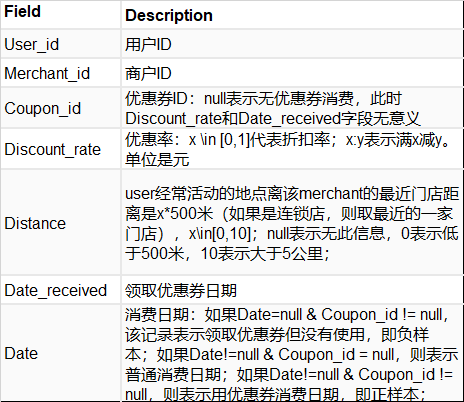



In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
from datetime import datetime

%matplotlib inline

In [114]:
offline = pd.read_csv('d:/python/exercise/samples/o2o/ccf_offline_stage1_train.csv', parse_dates = ['Date_received', 'Date'])

In [115]:
len(offline) #共175万条数据

1754884

In [116]:
offline.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,150:20,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,20:1,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,20:1,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,20:1,0.0,2016-06-13,NaT


### 2 数据规整

In [117]:
#空值判断
offline.isnull().sum()

User_id               0
Merchant_id           0
Coupon_id        701602
Discount_rate    701602
Distance         106003
Date_received    701602
Date             977900
dtype: int64

**把"Discount_rate"列中的满减转换为折扣率**

In [118]:
offline['Discount_rate'] = offline['Discount_rate'].fillna('null')

In [119]:
def calculate_discount(s):
    if ':' in s :
        split = s.split(':')
        discount_rate = (int(split[0]) - int(split[1])) / int(split[0])
        return round(discount_rate, 2)
    elif s == 'null':
        return np.nan
    else :
        return float(s)

In [120]:
offline['Discount_rate'] = offline['Discount_rate'].map(calculate_discount)

In [121]:
offline.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,0.87,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,0.95,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,0.95,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,0.95,0.0,2016-06-13,NaT


**根据文档描述，“Coupon_id”字段：null表示无优惠券消费，此时Discount_rate和Date_received字段无意义
检查“Coupon_id”和“Date_received”字段空值与非空值是否对应**

In [122]:
nan1 = offline['Coupon_id'].isnull()
nan2 = offline['Date_received'].isnull()
np.all(nan1 == nan2) #True表示“Coupon_id”和“Date_received”这两列的空值与非空值是一一对应的

True

In [123]:
nan3 = offline['Discount_rate'].isnull()
np.all(nan1 == nan3) #True表示“Coupon_id”和“Discount_rate”这两列的空值与非空值是一一对应的

True

**根据消费日期的字段描述：如果Date=null & Coupon_id != null，该记录表示领取优惠券但没有使用，即负样本；如果Date!=null & Coupon_id = null，则表示普通消费日期；如果Date!=null & Coupon_id != null，则表示用优惠券消费日期，即正样本**

**分别整理出如上各个样本集合**
1. 普通消费（nor_consume）:不用券消费
2. 有券没消费（cpon_no_consume）
3. 用券消费（cpon_consume）
4. 无券也没消费（no_cpon_no_consume）


In [124]:
nor_consume = offline[(offline['Coupon_id'].isnull()) & (offline['Date'].notnull())]  #普通消费（没券也买）

In [125]:
cpon_no_consume = offline[(offline['Coupon_id'].notnull()) & (offline['Date'].isnull())]  #有券没消费

In [126]:
cpon_consume = offline[(offline['Coupon_id'].notnull()) & (offline['Date'].notnull())]  #有券消费

In [127]:
no_cpon_no_consume = offline[(offline['Coupon_id'].isnull()) & (offline['Date'].isnull())]  #没券没消费

In [128]:
len(nor_consume)

701602

### 3 数据分析
**绘制各种消费方式情形的饼图**

In [129]:
consume_status_dict = {'nor_consume':len(nor_consume),'cpon_consume':len(cpon_consume),'cpon_no_consume':len(cpon_no_consume)}

In [130]:
consume_status = pd.Series(consume_status_dict)

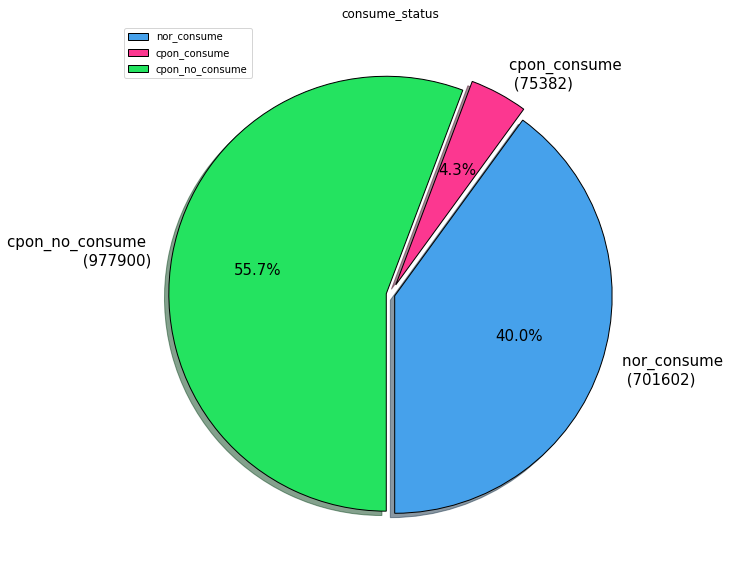

In [131]:
#消费方式构成的饼图
fig, ax = plt.subplots(1, 1, figsize = (10,10))
consume_status.plot.pie(ax = ax, 
                        autopct = '%1.1f%%',
                        startangle = -90, 
                        shadow = True, 
                        explode = [0.02,0.05,0.02],
                        colors = ['#46A1EB', '#FC3790', '#24E360'],
                        textprops = {'fontsize': 15, 'color': 'black'},
                        wedgeprops = {'linewidth': 1, 'edgecolor':'black'}, 
                        labels = ['nor_consume \n ({})'.format(len(nor_consume)), 
                                  'cpon_consume \n ({})'.format(len(cpon_consume)),
                                  'cpon_no_consume \n ({})'.format(len(cpon_no_consume))]
                                 )

ax.set_ylabel('')
ax.set_title('consume_status')
plt.legend(labels = ['nor_consume','cpon_consume','cpon_no_consume'], loc = 'upper left')

**在有券消费人群中，分析距离和优惠券折扣**

In [132]:
#各商家对应的顾客到店平均距离
Merchant_distance = cpon_consume.groupby(['Merchant_id'])['Distance'].mean()

In [133]:
#各商家对应的顾客到店消费平均折扣力度
Merchant_discount = cpon_consume.groupby('Merchant_id')['Discount_rate'].mean()

**持券到店消费顾客数最多的店家**

In [134]:
#顾客购买的每一件商品都形成一条记录，因此用unique将其去重

popular_merchant = cpon_consume.groupby(['Merchant_id'])['User_id'].agg(lambda x : len(x.unique())).sort_values(ascending = False)

#找出到店消费顾客数超过500的店家

popular_merchant500 = popular_merchant[popular_merchant >500]
popular_merchant500.name = 'customer_count'

**到店持券消费人数超过500人的店，连接顾客到店平均距离和平均折扣力度**

In [135]:
merchant_pop_dis = pd.merge(popular_merchant500, Merchant_distance,left_index=True, right_index=True)
merchant_pop_dis_rate = pd.merge(merchant_pop_dis, Merchant_discount, left_index = True, right_index = True)

In [136]:
merchant_pop_dis_rate

,customer_count,Distance,Discount_rate
Merchant_id,,,
5341,2800,0.168598,0.826036
760,2627,0.349866,0.799873
3381,2248,1.652429,0.744150
6485,2029,0.368567,0.770439
2099,1401,0.968072,0.900000
2934,1310,1.114833,0.830000
450,1094,0.892164,0.819274
3532,968,0.272498,0.852289
7555,925,1.329977,0.828381


**计算到店消费人数与平均距离和折扣力度的相关系数**

In [137]:
merchant_pop_dis_rate.corrwith(merchant_pop_dis_rate.customer_count)

customer_count    1.000000
Distance         -0.306180
Discount_rate    -0.204102
dtype: float64

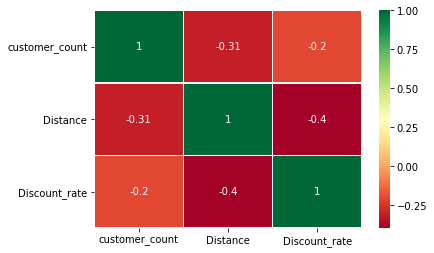

In [138]:
#用热力图看看
sns.heatmap(merchant_pop_dis_rate.corr(), annot = True, cmap='RdYlGn',linewidths=0.2)

**由计算结果可知：**
1. **到店消费人数多少与顾客到店距离呈负相关，相关系数0.3≤|r|≤0.5，说明线性相关程度为低度相关**
2. **到店消费人数与优惠券打折力度呈负相关，相关系数|r|≤0.3，说明线性相关程度极弱**

**因此，这些店家之所以火爆应该是物美价廉等品质因素带来的销量**

**接下来，从个人因素出发，分析哪些顾客对优惠券依赖程度较高**
**之前拆分的三个表中：cpon_consume和nor_consume表分别收集了有券消费的记录和不用券消费的普通购买记录等信息，采用横向对比的思路，在两个表中的这些顾客中，找出对于同一家店，有优惠券才消费，没有优惠券就不消费的一些顾客**




* **先来看看在cpon_consume表中却不在nor_consume表中的顾客人数**

In [139]:
len(np.setdiff1d(cpon_consume.User_id.values, nor_consume.User_id.values))

10476

* **这样单纯的从cpon_consume表中排除出现在nor_consume的顾客，感觉打击面有点过大**
<br>**比如：**

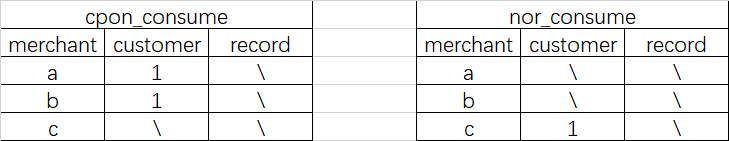
<br>例子中，1号顾客在a和b店都有过只有券才去的记录，但是在c店只进行过普通消费（也许是离家近买瓶水），按照上面的方法，1号顾客就会被排除在外，但他对于a店和b店是只有优惠券才去的。
所以以上方法这10476人中存在漏网之鱼

**采用如下方法把只在有优惠券才去某家店消费的所有顾客归纳出来**

In [140]:
no_cpon_shopping = nor_consume.groupby(['Merchant_id','User_id']).size()
no_cpon_shopping = no_cpon_shopping.reset_index('User_id').rename(columns={'User_id': 'user', 0:'times'})

In [141]:
cpon_shopping = cpon_consume.groupby(['Merchant_id', 'User_id']).size()
cpon_shopping = cpon_shopping.reset_index('User_id').rename(columns = {'User_id':'user', 0: 'times'})

In [142]:
shopping = pd.concat([cpon_shopping, no_cpon_shopping], keys = ['cpon', 'nor'])
shopping = shopping.reset_index(level=0).rename(columns = {'level_0': 'how'})

In [143]:
shopping.head()

,how,user,times
Merchant_id,,,
3,cpon,2651418,1
4,cpon,3931077,1
4,cpon,7083475,4
5,cpon,3181453,1
5,cpon,4167683,1


In [144]:
#把在cpon_consume而不在nor_consume中的顾客区分出来
def diff_mania(df):
    cpon = df[df['how'] == 'cpon']['user']
    nor = df[df['how'] == 'nor']['user']
    c = np.setdiff1d(cpon, nor)
    return pd.Series(c)

In [145]:
shopping_mania = shopping.groupby(level = 0).apply(diff_mania)

In [146]:
len(shopping_mania.unique())

14407

**这1万4千多人就是“除非这个店有打折，否则不买”的“购物狂”人群**

In [147]:
shopping_mania = shopping_mania.unique()

**选出这些购物狂和对应的消费记录**

In [148]:
shopping_mania_records = cpon_consume[cpon_consume['User_id'].isin(shopping_mania)]

In [149]:
shopping_mania_records.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
69,114747,6901,2366.0,0.83,0.0,2016-05-23,2016-06-05
75,114747,5341,111.0,0.83,0.0,2016-01-27,2016-02-21
76,114747,5341,111.0,0.83,0.0,2016-02-07,2016-02-18
77,114747,5341,7751.0,0.80,0.0,2016-01-27,2016-01-28
84,114747,2454,8088.0,0.75,0.0,2016-03-24,2016-03-31


In [150]:
len(shopping_mania_records)

21064

In [151]:
#做个对比表，分别对比距离、折扣和用掉优惠券时间
mania = [shopping_mania_records.Discount_rate.mean(),
         shopping_mania_records.Distance.mean(),
         (shopping_mania_records['Date'] - shopping_mania_records['Date_received']).mean().days]
all_cpon_consume = [cpon_consume.Discount_rate.mean(),
                    cpon_consume.Distance.mean(),
                    (cpon_consume['Date'] - cpon_consume['Date_received']).mean().days]


In [152]:
df = pd.DataFrame({'mania': mania, 'all': all_cpon_consume}, index = ['discount', 'distance', 'period'])

In [153]:
df

,mania,all
discount,0.829348,0.832929
distance,1.406087,1.014263
period,8.000000,7.000000


**由表可以看出，购物狂们花掉的优惠券折扣高于平均值，因此他们宁愿走更远的距离，但是看来并不急于花掉**

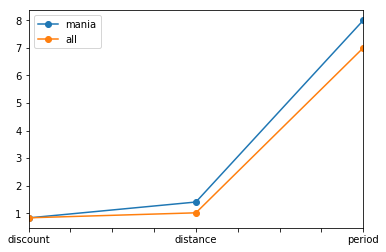

In [154]:
df.plot.line(linestyle = '-', marker='o' )

**下面再来分析一下每天中优惠券总体的发放与使用情况**

In [155]:
offline['Date'] = offline['Date'].dt.date

In [156]:
offline['Date_received'] = offline['Date_received'].dt.date

In [157]:
offline['Date'].notnull().sum()

776984

In [158]:
offline['Date_received'].notnull().sum()

1053282

In [159]:
date_sort = offline[offline['Date'].notnull()]['Date'].sort_values().unique()

In [160]:
date_receive_sort = offline[offline['Date_received'].notnull()]['Date_received'].sort_values().unique()

In [161]:
print('consume -- start with: ', date_sort[0].strftime('%Y-%m-%d'),' end with: ', date_sort[-1].strftime('%Y-%m-%d'))

consume -- start with:  2016-01-01  end with:  2016-06-30


In [162]:
print('receive -- start with: ', date_receive_sort[0].strftime('%Y-%m-%d'),' end with: ', date_receive_sort[-1].strftime('%Y-%m-%d'))

receive -- start with:  2016-01-01  end with:  2016-06-15


In [173]:
#每天优惠券使用数量
consume_num_everyday = cpon_consume[['User_id','Date_received']]
consume_num_everyday = consume_num_everyday.groupby(['Date_received'], as_index=False).count()
consume_num_everyday = consume_num_everyday.rename(columns= {'User_id':'count'})

In [174]:
#每天发放的优惠券数量
coupon_issue_everyday = offline[offline['Date_received'].notnull()][['Date_received','User_id']]
coupon_issue_everyday = coupon_issue_everyday.groupby(['Date_received'], as_index=False).count()
coupon_issue_everyday = coupon_issue_everyday.rename(columns={'User_id':'count'})

In [175]:
consume_num_everyday.head()

,Date_received,count
0,2016-01-01,74
1,2016-01-02,67
2,2016-01-03,74
3,2016-01-04,98
4,2016-01-05,107


In [176]:
coupon_issue_everyday.head()

,Date_received,count
0,2016-01-01,554
1,2016-01-02,542
2,2016-01-03,536
3,2016-01-04,577
4,2016-01-05,691


**每天发放的优惠券和每天被用掉的优惠券的数量对比和百分比柱状图**

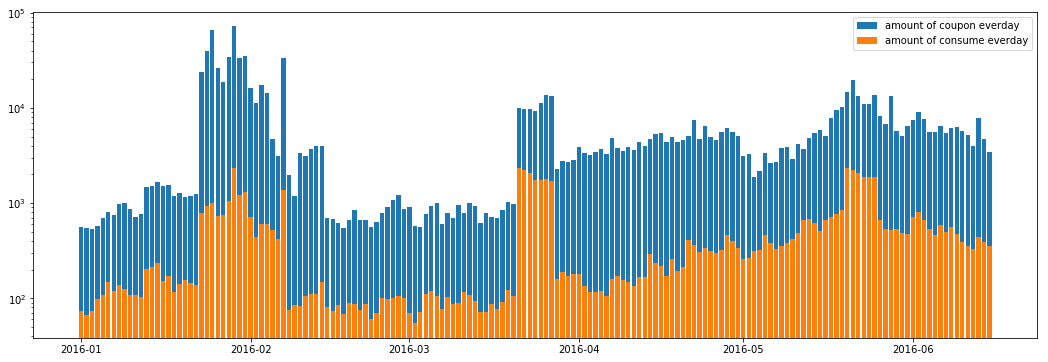

In [177]:
plt.figure(figsize=(18,6))
plt.bar(date_receive_sort, coupon_issue_everyday['count'], label = 'amount of coupon everday')
plt.bar(date_receive_sort, consume_num_everyday['count'], label = 'amount of consume everday')
plt.yscale('log')
plt.legend()

<BarContainer object of 167 artists>

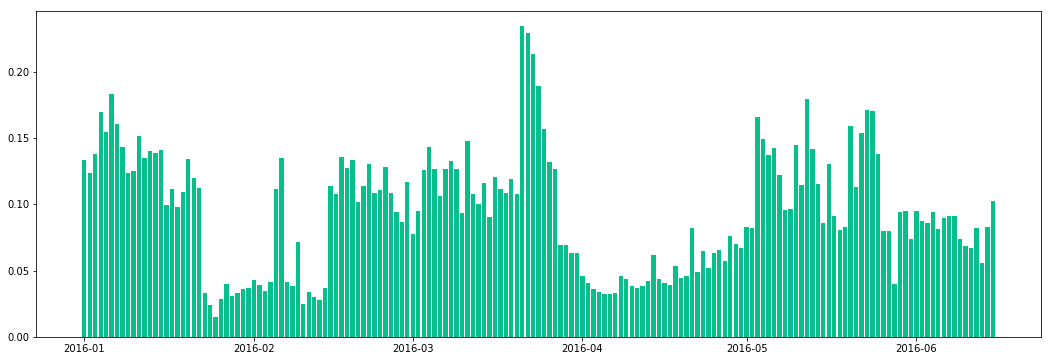

In [184]:
plt.figure(figsize=(18,6))
plt.bar(date_receive_sort, consume_num_everyday['count']/coupon_issue_everyday['count'], label = 'percent', color = ['#07BF8B'])



In [187]:
#总平均使用率
(consume_num_everyday['count'].sum())/(coupon_issue_everyday['count'].sum())

0.07156867771404049

## 五 结论

1. 顾客光顾最多的比较火爆的店面，并不受距离和打折力度影响，应该是商品品质或消费体验等水平较高所致
2. 各店家发放的优惠券，被使用总数和发放总数的比例不到一成，所以随机发放优惠券的效果并不理想，有很大的优化空间
3. 个性化投放是提高优惠券核销率的重要技术，它可以让具有一定偏好的消费者得到真正的实惠，通过分析发现，属于'shopping_mania'这个集合的1万4千多名消费者对于优惠券比较依赖，可以成为个性化发放的重点对象
4. 更进一步有针对性的个性化投放可以通过机器学习建模来拟合顾客的消费习惯，从而更精确的挖掘优惠券的适用对象